In [1]:
import pandas as pd
import numpy as np
import os
import pickle as pkl
import sklearn
import torch
import csv
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression

In [2]:
def read_files(directory):
    data = list()
    flag = True
    i = 0
    for filename in os.listdir(directory):
        filepath = os.path.join(directory,filename)
        temp_data = pd.read_csv(filepath,sep='|')
        sick = 0
        if 1 in temp_data['SepsisLabel'].unique():
            sick = 1
            idx = temp_data['SepsisLabel'].idxmax()
            temp_data = temp_data.head(idx)
        temp_data=temp_data.drop(['SepsisLabel'],axis=1)
        temp_data['is_sick'] = sick
        i += 1
        data.append((temp_data,sick,filename[filename.find('_')+1:filename.find('.')]))
    return data

In [3]:
train_data = read_files("data/train")

FileNotFoundError: [Errno 2] No such file or directory: 'data/train'

In [8]:
# Removing empty tables (all lables equal 1)
empty_train_data = []
for train in train_data:
    if train[0].empty:
        empty_train_data.append((train[2],train[1]))
train_data = [x for x in train_data if not x[0].empty]

In [9]:
### create database
database = pd.concat([data[0] for data in train_data])
median_db = database.median()

In [46]:
with open("median_database.pkl","wb") as file:
    pkl.dump(median_db,file)

# Feature Distribution

In [10]:
pd.options.display.max_columns = 100

In [11]:
database.describe(include='all')

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,is_sick
count,678538.000000,654658.000000,255554.000000,642728.000000,658945.000000,518271.000000,637038.000000,26007.000000,40722.000000,31026.000000,61381.000000,51990.000000,41505.000000,25991.000000,11831.000000,51361.000000,11706.000000,43791.000000,33709.000000,45598.000000,1391.000000,129266.000000,19627.000000,47123.000000,29721.000000,69889.000000,10917.000000,7269.000000,66646.000000,55450.000000,21728.000000,47965.000000,4779.000000,44457.000000,753402.000000,753402.000000,460337.000000,460337.000000,753402.000000,753402.000000,753402.000000
mean,84.549167,97.196368,36.972246,123.551667,82.336708,63.818172,18.720971,33.053832,-0.773254,24.082429,0.589373,7.377294,41.125069,92.485239,263.395444,23.408043,100.936870,7.561889,105.898662,1.486689,1.536614,136.994924,2.676260,2.047412,3.536178,4.136696,1.961267,8.205752,30.827725,10.440317,41.207787,11.406636,284.601737,196.848768,62.032840,0.554967,0.493404,0.506596,-54.686831,26.058711,0.092000
std,17.339752,2.943954,0.770302,23.127924,16.281421,13.894764,5.085948,8.007455,4.288205,4.374448,16.145520,0.074635,9.311791,11.067124,879.678337,19.637202,111.697729,2.428739,5.801351,1.769295,3.095991,51.131868,2.540196,0.398004,1.414140,0.646103,3.883075,24.576590,5.496554,1.967976,26.447786,7.386235,151.771845,103.646951,16.409561,0.496970,0.499957,0.499957,168.382039,26.854163,0.289026
min,20.000000,20.000000,20.900000,20.000000,20.000000,20.000000,1.000000,10.000000,-32.000000,0.000000,-50.000000,6.620000,10.000000,26.000000,5.000000,1.000000,11.000000,1.000000,74.000000,0.100000,0.010000,10.000000,0.200000,0.600000,0.300000,1.300000,0.100000,0.010000,8.800000,2.600000,17.100000,0.100000,35.000000,2.000000,15.000000,0.000000,0.000000,0.000000,-5366.860000,1.000000,0.000000
25%,72.000000,96.000000,36.500000,107.000000,71.000000,54.000000,15.000000,28.000000,-3.000000,22.000000,0.400000,7.340000,36.000000,94.000000,22.000000,12.000000,53.000000,7.600000,103.000000,0.700000,0.200000,106.000000,1.280000,1.800000,2.600000,3.700000,0.500000,0.040000,27.000000,9.100000,27.800000,7.600000,181.000000,128.000000,51.640000,0.000000,0.000000,0.000000,-45.440000,11.000000,0.000000
50%,83.000000,98.000000,37.000000,121.000000,80.000000,62.000000,18.000000,33.000000,0.000000,24.000000,0.500000,7.380000,40.000000,97.000000,40.000000,17.000000,73.000000,8.300000,106.000000,0.910000,0.400000,127.000000,1.870000,2.000000,3.300000,4.100000,0.800000,0.300000,30.300000,10.300000,32.300000,10.300000,248.000000,182.000000,64.000000,1.000000,0.000000,1.000000,-5.980000,21.000000,0.000000
75%,95.500000,99.500000,37.500000,138.000000,92.000000,72.000000,21.500000,38.000000,1.000000,26.000000,0.600000,7.430000,45.000000,98.000000,109.000000,28.000000,106.000000,8.700000,109.000000,1.400000,1.550000,153.000000,3.000000,2.200000,4.100000,4.400000,1.600000,4.000000,34.200000,11.700000,42.300000,13.700000,348.000000,244.000000,74.000000,1.000000,1.000000,1.000000,-0.040000,34.000000,0.000000
max,280.000000,100.000000,50.000000,299.000000,300.000000,300.000000,100.000000,100.000000,49.500000,55.000000,4000.000000,7.780000,100.000000,100.000000,9961.000000,268.000000,2528.000000,27.900000,145.000000,41.900000,35.000000,952.000000,31.000000,9.800000,17.600000,27.500000,49.600000,440.000000,71.700000,25.000000,250.000000,440.000000,1760.000000,2322.000000,100.000000,1.000000,1.000000,1.000000,17.340000,336.000000,1.000000


<AxesSubplot:>

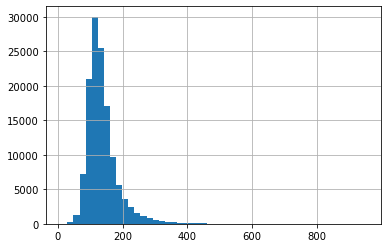

In [12]:
database['Glucose'].hist(bins=50)

In [4]:
corr = database.corr()

In [5]:
corr.style.background_gradient(cmap='coolwarm')

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,is_sick
HR,1.000000,-0.078193,0.257758,-0.034486,0.066310,0.128069,0.226596,0.006766,-0.084497,-0.076979,0.004737,-0.102142,0.029346,-0.013014,0.037147,-0.027107,0.032044,-0.099466,0.004639,-0.021337,0.017900,0.079878,0.138924,-0.066169,-0.049088,0.011600,0.001108,-0.001131,-0.076070,-0.075127,0.016418,0.140947,0.078604,0.027880,-0.154639,-0.028761,-0.007548,0.007548,-0.048480,0.047724,0.062678
O2Sat,-0.078193,1.000000,-0.034192,0.023486,0.022303,-0.002189,-0.148342,-0.025781,0.032573,-0.076649,0.000939,0.118156,-0.131974,0.090618,0.003238,-0.044507,-0.018919,-0.046897,0.162354,-0.010706,-0.009440,-0.017292,-0.182632,-0.023486,-0.046144,-0.034218,-0.022290,-0.005143,-0.126365,-0.108678,-0.060023,-0.020829,-0.077721,-0.029449,-0.048429,-0.034229,-0.041206,0.041206,-0.012625,-0.048365,0.014980
Temp,0.257758,-0.034192,1.000000,0.004513,-0.062065,-0.105135,0.116750,0.203564,0.167443,0.073815,-0.005858,0.216923,-0.042422,-0.020644,-0.009428,-0.121532,-0.060494,-0.005686,-0.045976,-0.086052,-0.032877,-0.066196,-0.250350,-0.051165,-0.163761,0.049590,-0.046462,-0.034181,-0.048409,-0.037993,-0.119631,0.028802,0.272621,0.005843,-0.071503,0.055244,-0.218944,0.218944,-0.002225,0.081442,0.063370
SBP,-0.034486,0.023486,0.004513,1.000000,0.781841,0.542446,0.041117,0.070387,0.150995,0.061764,-0.005822,0.121719,0.020342,0.096199,-0.004295,0.006089,-0.021316,0.047409,-0.039213,0.077740,-0.044591,0.038678,-0.133143,-0.025715,-0.030382,-0.096897,-0.052601,-0.116542,0.092415,0.072619,-0.109558,-0.042839,0.080081,0.025340,0.031005,-0.015200,0.056469,-0.056469,0.027811,0.052926,0.011951
MAP,0.066310,0.022303,-0.062065,0.781841,1.000000,0.851375,0.045224,0.054899,0.112407,0.028703,-0.005214,0.093314,0.009191,0.081906,0.004701,-0.044681,-0.019009,0.035066,-0.004160,0.059594,-0.060019,0.036459,-0.067345,-0.037109,-0.036711,-0.097235,-0.056240,-0.062746,0.175687,0.146391,-0.066754,-0.055284,0.063565,0.043675,-0.144701,0.000519,0.125084,-0.125084,0.036306,0.029714,-0.004916
DBP,0.128069,-0.002189,-0.105135,0.542446,0.851375,1.000000,0.061506,0.053975,0.081778,0.039787,-0.003912,0.058319,0.012160,0.058136,0.001474,-0.047819,0.001237,0.065517,-0.014560,0.056404,-0.071334,0.035692,-0.024686,-0.046897,-0.031154,-0.092270,-0.047825,-0.009968,0.239746,0.211448,-0.040666,-0.061317,0.038464,0.088674,-0.266905,0.024584,0.224819,-0.224819,0.042096,0.010063,-0.028574
Resp,0.226596,-0.148342,0.116750,0.041117,0.045224,0.061506,1.000000,-0.154355,-0.040991,-0.029338,-0.001025,-0.001111,-0.032021,-0.030334,0.002393,0.064565,0.044330,0.020515,-0.088448,0.009613,0.002242,0.033289,0.105952,-0.006811,-0.044373,0.008875,-0.010361,0.004970,0.019650,0.001124,0.055377,0.054468,0.114257,0.071087,0.032227,0.003906,0.087329,-0.087329,-0.017772,0.097189,0.069119
EtCO2,0.006766,-0.025781,0.203564,0.070387,0.054899,0.053975,-0.154355,1.000000,0.036185,0.141093,-0.047638,-0.010156,0.421088,0.069698,-0.149066,-0.075469,-0.070716,0.087899,-0.020300,-0.079500,-0.266324,-0.019716,-0.324281,0.036089,0.052828,-0.071144,-0.140953,0.011961,0.094167,0.056606,-0.162295,-0.035634,0.171778,0.201149,-0.149846,-0.025431,-0.002496,0.002496,0.000411,0.061396,0.011217
BaseExcess,-0.084497,0.032573,0.167443,0.150995,0.112407,0.081778,-0.040991,0.036185,1.000000,0.848225,-0.136944,0.657391,0.349879,0.053327,-0.044761,-0.199141,-0.075787,0.192371,-0.329489,-0.250639,0.006601,-0.159322,-0.475843,-0.007506,-0.341480,-0.227545,-0.006016,-0.090932,-0.055928,-0.040059,-0.271893,-0.178154,0.127642,0.097026,-0.043123,0.040312,0.037188,-0.037188,-0.019491,0.145237,0.035716
HCO3,-0.076979,-0.076649,0.073815,0.061764,0.028703,0.039787,-0.029338,0.141093,0.848225,1.000000,-0.092505,0.396031,0.535654,-0.001634,-0.094777,-0.165461

In [108]:
female = database[database['Gender']==0]
male = database[database['Gender']==1]

In [109]:
print(ttest_ind(female['is_sick'],male['is_sick']))

Ttest_indResult(statistic=-8.033970622579778, pvalue=9.450235717687868e-16)


# MIssing Data

In [15]:
### print database description and missing value % per category (should be 0 now)

pd.set_option('display.max_columns', None)
# print(database.describe())
percent_missing = database.isnull().sum() * 100 / len(database)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
print(missing_value_df)

                  percent_missing
HR                       9.936793
O2Sat                   13.106416
Temp                    66.079994
SBP                     14.689900
MAP                     12.537397
DBP                     31.209235
Resp                    15.445141
EtCO2                   96.548058
BaseExcess              94.594917
HCO3                    95.881880
FiO2                    91.852822
pH                      93.099302
PaCO2                   94.490989
SaO2                    96.550182
AST                     98.429656
BUN                     93.182790
Alkalinephos            98.446248
Calcium                 94.187565
Chloride                95.525762
Creatinine              93.947720
Bilirubin_direct        99.815371
Glucose                 82.842360
Lactate                 97.394883
Magnesium               93.745305
Phosphate               96.055094
Potassium               90.723545
Bilirubin_total         98.550973
TroponinI               99.035176
Hct           

# Predictions

In [10]:
test_data = read_files("data/test")

In [11]:
# Remove empty tables
empty_test_data = []
for test in test_data:
    if test[0].empty:
        empty_test_data.append((test[2],test[1]))
test_data = [x for x in test_data if not x[0].empty]

In [12]:
for i in range(len(train_data)):
    train_data[i] = (train_data[i][0].ffill().bfill(),train_data[i][1],train_data[i][2]) # pottentially add limit=number inside the fill function

In [13]:
for i in range(len(test_data)):
    test_data[i] = (test_data[i][0].ffill().bfill(),test_data[i][1],test_data[i][2]) # pottentially add limit=number inside the fill function

In [14]:
### fill the missing train data with medians
for i in range(len(train_data)):
    temp = train_data[i][0]
    for col in train_data[0][0].columns:
        temp[col].fillna(median_db[col],inplace=True)
    train_data[i] = (temp,train_data[i][1],train_data[i][2])

In [15]:
### fill the missing test data with medians
for i in range(len(test_data)):
    temp = test_data[i][0]
    for col in test_data[0][0].columns:
        temp[col].fillna(median_db[col],inplace=True)
    test_data[i] = (temp,test_data[i][1],test_data[i][2])

In [16]:
# Adding columns for train data
for i in range(len(train_data)):
    train_data[i][0]['HRESP'] = train_data[i][0]['HR']*train_data[i][0]['Resp']
    train_data[i][0]['NBTemp'] = train_data[i][0]['Temp']-37
    train_data[i][0]['HRTemp'] = train_data[i][0]['NBTemp']*train_data[i][0]['HR']
    train_data[i][0]['RespTemp'] = train_data[i][0]['NBTemp']*train_data[i][0]['Resp']
    train_data[i][0]['HRGlue'] = train_data[i][0]['HR']*train_data[i][0]['Glucose']
    train_data[i][0]['NBGlue'] = train_data[i][0]['NBTemp']*train_data[i][0]['Glucose']
    train_data[i][0]['RespGlue'] = train_data[i][0]['Resp']*train_data[i][0]['Glucose']

In [17]:
# Adding columns for test data
for i in range(len(test_data)):
    test_data[i][0]['HRESP'] = test_data[i][0]['HR']*test_data[i][0]['Resp']
    test_data[i][0]['NBTemp'] = test_data[i][0]['Temp']-37
    test_data[i][0]['HRTemp'] = test_data[i][0]['NBTemp']*test_data[i][0]['HR']
    test_data[i][0]['RespTemp'] = test_data[i][0]['NBTemp']*test_data[i][0]['Resp']
    test_data[i][0]['HRGlue'] = test_data[i][0]['HR']*test_data[i][0]['Glucose']
    test_data[i][0]['NBGlue'] = test_data[i][0]['NBTemp']*test_data[i][0]['Glucose']
    test_data[i][0]['RespGlue'] = test_data[i][0]['Resp']*test_data[i][0]['Glucose']

In [18]:
### Averaging the train data, romoving Unit2
avg_train_data = []
classification_train = []
id_train = []
for item in train_data:
    avg_train_data.append(item[0].drop(['is_sick','Unit2'],axis=1,inplace=False).mean().to_numpy())
    classification_train.append(item[1])
    id_train.append(int(item[2]))

In [19]:
### Averaging the test data, removing Unit2
avg_test_data = []
classification_test = []
id_test = []
for item in test_data:
    avg_test_data.append(item[0].drop(['is_sick','Unit2'],axis=1,inplace=False).mean().to_numpy())
    classification_test.append(item[1])
    id_test.append(int(item[2]))

In [26]:
### Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X,y = [], []


X_train, X_test, y_train, y_test = train_test_split(avg_train_data, classification_train, test_size=0.33, random_state=42)
clf = LogisticRegression(max_iter=100000,random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("logistic regression on validation score: ",f1_score(y_test,y_pred))
y_pred = clf.predict(X_train)
print("logistic regression on train score: ",f1_score(y_train,y_pred))

logistic regression on validation score:  0.1461187214611872
logistic regression on train score:  0.1340782122905028


In [25]:
X_train = avg_train_data
y_train = classification_train
X_test = avg_test_data
y_test = classification_test
clf = LogisticRegression(max_iter=100000,random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("logistic regression test (withot missing data) score: ", f1_score(y_test,y_pred))

logistic regression test (withot missing data) score:  0.13559322033898305


In [23]:
y_test = classification_test.copy()
y_pred = list(y_pred)
for item in empty_test_data:
    y_pred.append(1)
    y_test.append(item[1])
print("logistic regression test (with missing data) score: ", f1_score(y_test,y_pred))

logistic regression test (with missing data) score:  0.32420591456736036


In [27]:
### Decision Tree
from sklearn import tree
X,y = [], []


X_train, X_test, y_train, y_test = train_test_split(avg_train_data, classification_train, test_size=0.33, random_state=42)
clf = tree.DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("tree score on validation: ",f1_score(y_test,y_pred))
y_pred = clf.predict(X_train)
print("tree score on train: ", f1_score(y_train,y_pred))

tree score on validation:  0.49532710280373826
tree score on train:  1.0


In [30]:
X_train = avg_train_data
y_train = classification_train
X_test = avg_test_data
y_test = classification_test
clf = tree.DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("tree score on test (withot missing data): ", f1_score(y_test,y_pred))

tree score on test (withot missing data):  0.4896710022953328


In [31]:
y_test = classification_test.copy()
y_pred = list(y_pred)
for item in empty_test_data:
    y_pred.append(1)
    y_test.append(item[1])
print("tree score on test (with missing data): ", f1_score(y_test,y_pred))

tree score on test (with missing data):  0.5603164139749506


In [32]:
### Random Forest - train
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X,y = [], []


X_train, X_test, y_train, y_test = train_test_split(avg_train_data, classification_train, test_size=0.33, random_state=42)
clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = list(y_pred)
print("random forest on validation score:",f1_score(y_test,y_pred))
y_pred = clf.predict(X_train)
print("random forest on train score: ", f1_score(y_train,y_pred))

random forest on validation score: 0.6174055829228243
random forest on train score:  0.9993891264508247


In [33]:
### Random Forest - test

X_train = avg_train_data
X_test = avg_test_data
y_train = classification_train
y_test = classification_test.copy()
clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = list(y_pred)
print("random forest on test (without missing data) score:",f1_score(y_test,y_pred))

random forest on test (without missing data) score: 0.5758513931888545


In [34]:
### Random Forest - test

X_train = avg_train_data
X_test = avg_test_data
y_train = classification_train
y_test = classification_test.copy()
clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = list(y_pred)
for item in empty_test_data:
    y_pred.append(1)
    y_test.append(item[1])
    id_test.append(int(item[0]))
print("random forest on test (with missing data) score:",f1_score(y_test,y_pred))

random forest on test (with missing data) score: 0.6513994910941475


In [65]:
with open("model.pkl","wb") as file:
    pkl.dump(clf,file)

In [47]:
predictions = {"ids":id_test,"SepsisLabel":y_pred}

In [48]:
# Check ids
pred_df = pd.DataFrame(predictions)
pred_df

,ids,SepsisLabel
0,8726,0
1,5105,0
2,4068,0
3,2791,0
4,690,0
...,...,...
9995,684,1
9996,6481,1
9997,9237,1
9998,9943,1


In [49]:
# Check ids
pred_df.sort_values(["ids"],inplace=True)
pred_df

,ids,SepsisLabel
8416,0,0
9847,1,0
652,2,0
8983,3,0
9674,4,0
...,...,...
1570,9995,0
1008,9996,0
9231,9997,0
2741,9998,0


In [50]:
pred_df.to_csv("prediction.csv",index=False,header=False)

In [51]:
### Rnn
from sklearn.model_selection import train_test_split
import math

X = []
y = []
for data in train_data:
    X.append(data[0].drop(['is_sick','Unit2'],axis=1,inplace=False).to_numpy())   
X = np.array(X)
y = np.array(classification_train)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

    
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(14851,) (14851,)
(4951,) (4951,)


<ipython-input-51-6b474841d769>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [53]:
input_size = len(X_train[0][0])
output_size = 2
all_categories = [0,1]
X_1 = []
X_0 = []
for i in range(len(y_train)):
    if y_train[i] == 1:
        X_1.append(X_train[i])
    else:
        X_0.append(X_train[i])
X_1 = np.array(X_1)
X_0 = np.array(X_0)

<ipython-input-53-162d4599b9ab>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_1 = np.array(X_1)
<ipython-input-53-162d4599b9ab>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_0 = np.array(X_0)


In [54]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden))
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.logsoftmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0].float()

n_hidden = 128

In [55]:
def categoryFromOutput(output):
    max_val, argmax = output.max(dim=0,  keepdim=True) 
    category_i = argmax.item()
    return all_categories[category_i], category_i

In [56]:
def lineToTensor(line):
    return torch.from_numpy(line).float()

In [94]:
print(X_0.shape)
print(X_1.shape)

(13930,)
(921,)


In [112]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    
    if category == 0:
        line = randomChoice(X_0)
    else:
        line = randomChoice(X_1)

    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(2):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f'category = {category_tensor}, line = {line_tensor}')
    print(line_tensor.size()[0])

category = tensor([0]), line = tensor([[   74.0000,    99.0000,    37.1000,  ...,  9916.0000,    13.4000,
          2948.0000],
        [   74.0000,    99.0000,    37.1000,  ...,  9916.0000,    13.4000,
          2948.0000],
        [   76.5000,    93.5000,    37.1000,  ..., 10251.0000,    13.4000,
          2948.0000],
        ...,
        [   57.0000,    97.0000,    36.6000,  ...,  9177.0000,   -64.4000,
          2415.0000],
        [   52.0000,    97.0000,    36.6000,  ...,  8372.0000,   -64.4000,
          2737.0000],
        [   52.0000,   100.0000,    36.6000,  ...,  8372.0000,   -64.4000,
          2415.0000]])
42
category = tensor([0]), line = tensor([[   96.0000,   100.0000,    35.4000,  ..., 11520.0000,  -192.0000,
          2280.0000],
        [   96.0000,   100.0000,    35.4000,  ..., 11520.0000,  -192.0000,
          2280.0000],
        [  102.0000,    99.5000,    36.1000,  ..., 12240.0000,  -108.0000,
          1680.0000],
        ...,
        [  104.0000,    99.0000,   

In [113]:
rnn = RNN(input_size, n_hidden, output_size)
learning_rate = 0.0001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# category_tensor: 0/1, line_tensor: patient
def train(category_tensor, line_tensor):
    
    hidden = rnn.initHidden()
    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor[0])
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [114]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
current_loss2 = 0
all_losses = []


for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if not math.isnan(loss):
        current_loss2 += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f / %s %s' % (iter, iter / n_iters * 100,
                                                current_loss2/print_every,
                                                guess, correct))
        current_loss2 = 0

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

        

5000 5% 21.5910 / 0 ✗ (1)
10000 10% 11.6887 / 1 ✓
15000 15% 7.9877 / 1 ✗ (0)
20000 20% 6.0540 / 0 ✓
25000 25% 5.4444 / 0 ✓
30000 30% 4.3706 / 1 ✓
35000 35% 3.8464 / 1 ✓
40000 40% 3.8164 / 0 ✓
45000 45% 3.1855 / 1 ✗ (0)
50000 50% 3.0596 / 0 ✓
55000 55% 2.7760 / 1 ✓
60000 60% 2.4355 / 1 ✓
65000 65% 2.4850 / 1 ✓
70000 70% 2.3183 / 1 ✓
75000 75% 1.8928 / 1 ✓
80000 80% 1.9340 / 1 ✗ (0)
85000 85% 2.1391 / 0 ✓
90000 90% 1.7802 / 1 ✓
95000 95% 1.9195 / 1 ✗ (0)
100000 100% 1.6582 / 0 ✗ (1)


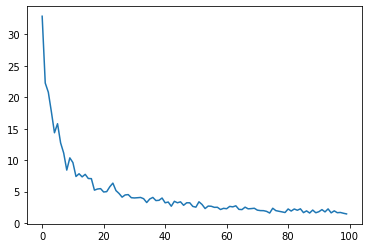

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(all_losses)
plt.show()

In [116]:
def predict(line_tensor):
    
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return categoryFromOutput(output)[0]

In [117]:
val_outputs = []
for item in X_val:
    line_tensor = lineToTensor(item)
    output = predict(line_tensor)
    val_outputs.append(output)

In [118]:
print("RNN score on validation: ",f1_score(y_val,val_outputs))

RNN score on validation:  0.47328244274809156


In [119]:
val_outputs = []
for item in X_train:
    line_tensor = lineToTensor(item)
    output = predict(line_tensor)
    val_outputs.append(output)

In [120]:
print("RNN score on train set: ",f1_score(y_train,val_outputs))

RNN score on train set:  0.4909090909090909


In [124]:
X_test = []
for i in range(len(test_data)):
    X_test.append(test_data[i][0].drop(['is_sick','Unit2'],axis=1,inplace=False).to_numpy())
y_test = classification_test.copy()

In [127]:
test_outputs = []
for item in X_test:
    line_tensor = lineToTensor(item)
    output = predict(line_tensor)
    test_outputs.append(output)

In [128]:
print("RNN score on test set (without missing data): ",f1_score(y_test,test_outputs))

RNN score on test set (without missing data):  0.49640287769784175


In [129]:
for item in empty_test_data:
    test_outputs.append(1)
    y_test.append(item[1])

In [130]:
print("RNN score on test set (with missing data): ",f1_score(y_test,test_outputs))

RNN score on test set (with missing data):  0.5763993948562784
